LNK02 based on Spike Feedback Model from Leo by adding nonlinearity and kinetic model after filter output

Update history: Dec 25, 2021 created by ckc

Ozuysal, Y. and S. A. Baccus (2012). "Linking the Computational Structure of Variance Adaptation to Biophysical Mechanisms." Neuron 73(5): 1002-1015.

# Import and functions

In [174]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

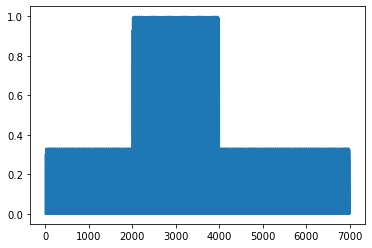

In [175]:
dt = 0.01
x = np.sin(1*np.arange(int(70/dt)))

HC = 1
LC = 1/3

x = x*LC
x[int(20/dt):int(40/dt)] = x[int(20/dt):int(40/dt)]*HC/LC

x[x<0] = 0

plt.plot(x)

# LNK

In [176]:
# four states kinetic model
# using the same notation as Ozuysal
# Eqn(11) in "Experimental Procedure" section

def kinetic(u,para,dt):
    ka  = para[0]
    kfr = para[1]
    kfi = para[2]
    ksr = para[3]
    ksi = para[4]
#   initial conditions for the four states
    p1 = 0.8
    p2 = 2.0
    p3 = 0.2
    p4 = 97.0

    p1r = []
    p2r = []
    p3r = []
    p4r = []
#
# 
#
    for i in range(len(u)):
        dp1 = (-u[i]*ka*p1  + kfr*p3)*dt
        dp2 =  (u[i]*ka*p1     - kfi*p2)*dt
        dp3 =  (kfi*p2 - (kfr+ksi)*p3 + u[i]*ksr*p4)*dt
        dp4 =  (ksi*p3 - u[i]*ksr*p4)*dt
    
        p1 = p1 + dp1
        p2 = p2 + dp2
        p3 = p3 + dp3
        p4 = p4 + dp4
    
        p1r.append(p1)
        p2r.append(p2)
        p3r.append(p3)
        p4r.append(p4)
        
# turn list into numpy arrays
    p1r = np.array(p1r)
    p2r = np.array(p2r)
    p3r = np.array(p3r)
    p4r = np.array(p4r)
    return (p1r,p2r,p3r,p4r)

In [177]:
# Nonlinearity function
# midpoint = 0.25 # position of the mid point of the nonlinear function (tanh)
# DR = 5 # dynamical range (?) of the nonlinear function (tanh)
# dummy = np.linspace(-1,1,1000)
# plt.plot(dummy, (np.tanh((dummy-midpoint)*DR)+1)/2)

In [178]:
# u = (np.tanh((x-midpoint)*DR)+1)/2

para = [60,20,3,0.03,1.0] # parameters for the five rates from Figure 2

R,A,I1,I2 =kinetic(x,para,dt)

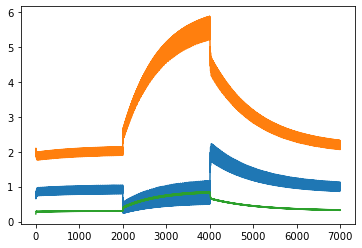

In [179]:
# Action pool = output of the system
plt.plot(R)
plt.plot(A)
plt.plot(I1)
# plt.plot(I2)

# GC

In [180]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

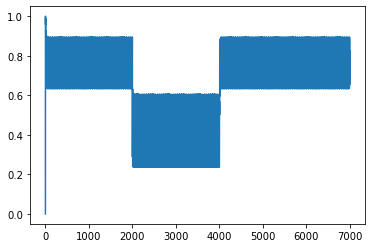

In [185]:
B = 100 #To tune altitude of gain control (D=1/T) 4000; 5000
tau = 0.1

GC_Output, gain = AddGainControl(x, B, tau)
plt.plot(gain)

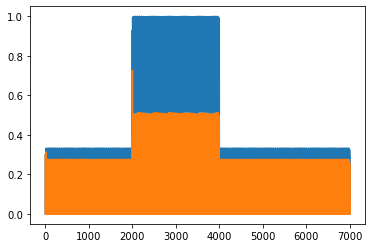

In [186]:
plt.plot(x)
plt.plot(GC_Output)
